In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize
import ddm

Let's write a simple model which could capture the following empirical observations (for an average subject first, we'll deal with individual differences later)
 - Drivers use two perceptual quantities in making a decision: distance (d) and time-to-arrival (TTA)
 - Probability of turning increases with both d and TTA
 - Response time increases with TTA
 - Response time decreases with d

In [114]:
def dx(A, c, dt):
    return A*dt + c*np.random.randn()*np.sqrt(dt)

def run_trial(tta, params, n):
    noise_intensity = 1.0
    nondecision_time = 0.0
    boundary, tta_crit = params
    
    # our decisions are on the timescale of 1-2 seconds, we use 10ms as integration step for testing purposes
    # TODO: change to better time resolution (at most dt = 0.001)
    dt = 0.01

    # for each trial, we will store the whole dynamics of the simulation, include timestamps, and for 
    # each timestamp (t): current drift rate (tta), current evidence value (x)
    timestamps = [0]
    drift_rate_values = [tta-tta_crit]
    evidence_values = [0]

    while (abs(evidence_values[-1]) < boundary):
        t = timestamps[-1] + dt

        # drift rate at time t
        drift_rate = drift_rate_values[0]-t
        drift_rate_values.append(drift_rate)

        # accumulated evidence at time t
        evidence_values.append(evidence_values[-1] + dx(drift_rate, noise_intensity, dt))
        timestamps.append(t)

    is_turn_decision = (evidence_values[-1] > boundary)
        
    return pd.DataFrame(data={'n': n,
                              't': np.array(timestamps) + nondecision_time,
                              'x': np.array(evidence_values),
                              'd': np.array(drift_rate_values),
                              'is_turn_decision': is_turn_decision})

def run_sim(tta, params, n_sim):
    trials = [run_trial(tta, params, n) for n in range(n_sim)]
    sim_result = pd.concat(trials).set_index(['n'])
    sim_result['tta_condition'] = tta
    
    return sim_result 

In [3]:
def plot_ddm_traces(sim_data, axes=None):
    turn_rate = sim_data.groupby('n').is_turn_decision.last().mean()
    mean_turn_rt = sim_data[sim_data.is_turn_decision].groupby('n').t.last().mean()
    
    if axes is None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
        axes = (ax1, ax2, ax3)
    else:
        (ax1, ax2, ax3) = axes
    
    t = np.linspace(0, 3, 10)
    ax2.plot(t, sim_data.d.iloc[0]-t, color='grey')
    
    for n, traj in sim_data.groupby('n'):
        is_turn_decision = traj.is_turn_decision.iloc[-1]
        color = 'C1' if is_turn_decision else 'C2'
        alpha = 0.3 if is_turn_decision else 0.1
        ax1.plot(traj.t, traj.x, color=color, alpha=alpha)
        ax2.plot([traj.t.values[-1]], [traj.d.values[-1]], color=color, marker='o', alpha=alpha)
    
    response_times = sim_data[sim_data.is_turn_decision].groupby('n').t.last()
    sns.kdeplot(ax=ax3, data=response_times, color='C1', shade=True, legend=False)

    ax1.set_ylabel('evidence $x$')
    ax2.set_ylabel('$tta-tta_{crit}$')
    ax3.set_ylabel('probability')    
    
    ax1.set_xlabel('time $t$')
    ax2.set_xlabel('time $t$')
    ax2.set_xlabel('RT')
    
    ax2.set_title('Turn rate$=%.f\%%$, mean turn RT $=%.2f$s' % (100*turn_rate, mean_turn_rt))
    plt.subplots_adjust(hspace=0.2)
    sns.despine(trim=True, offset=5)
    
    return axes

# Simulating simple DDM for three TTA values

For a given set of parameters, let's simulate the model for different TTA values

In [67]:
params = (1.0, 4.0)

TTA=4

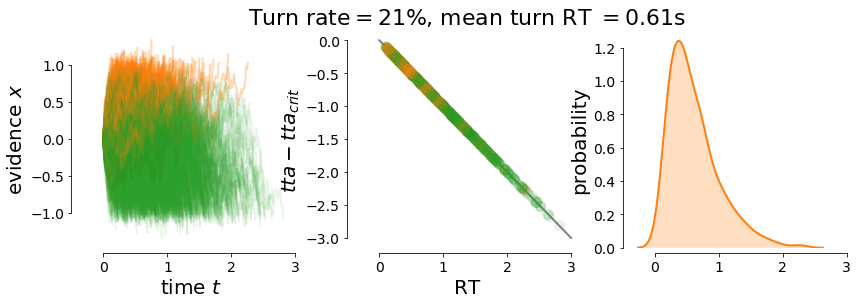

In [7]:
sim_data_4 = run_sim(tta=4, params=params, n_sim=1000)
axes = plot_ddm_traces(sim_data_4)

TTA=5

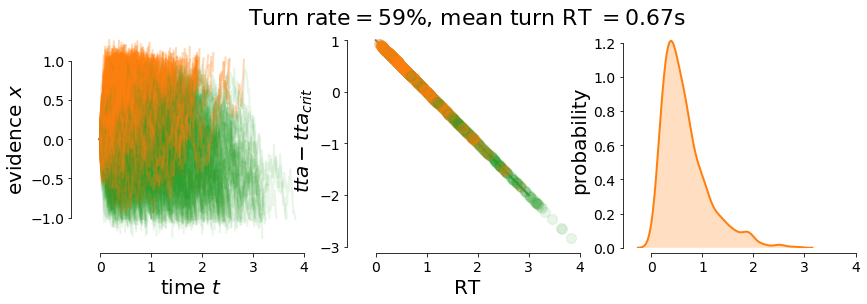

In [38]:
sim_data_5 = run_sim(tta=5, params=params, n_sim=1000)
axes = plot_ddm_traces(sim_data_5)

TTA=6

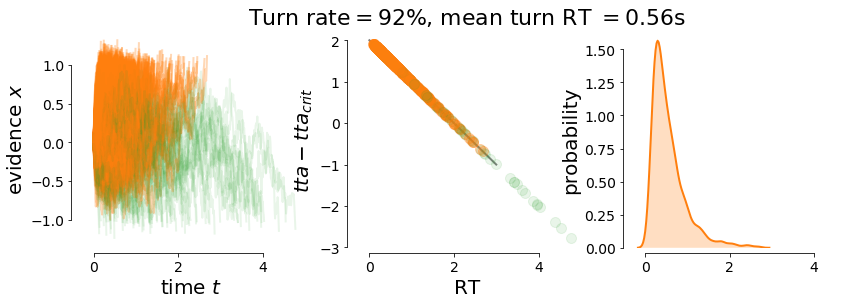

In [39]:
sim_data_6 = run_sim(tta=6, params=params, n_sim=1000)
axes = plot_ddm_traces(sim_data_6)

# Fitting the model to the data (ignoring distance condition)

First, focus on TTA as IV. For a given set of parameters, plot the same results I have for experimental data: psychometric function, RT for turn decisions; come up with a moderately reasonable measure of fit (combination of delta p and delta RT)

In [76]:
def get_model_sim_results(params):  
#     print('boundary: %.2f, tta_crit: %.2f' % (params))
    print(params)
    return pd.concat(
            [run_sim(tta=tta, params=params, n_sim=1000) 
             for tta in [4, 5, 6]])

In [5]:
def plot_comparison(exp_measures, sim_measures):
    ax = sns.pointplot(data=exp_measures, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures, x='tta_condition', y='is_turn_decision', marker='o', color='grey')
    ax.set_ylabel('p(turn)')
    plt.figure()
    ax = sns.pointplot(data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures[sim_measures.is_turn_decision], 
                  x='tta_condition', y='RT', marker='o', color='grey')

boundary: 1.00, tta_crit: 4.00


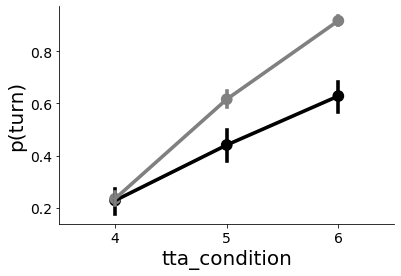

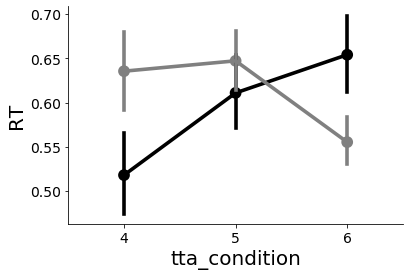

In [74]:
sim_results = get_model_sim_results(params)
sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
exp_measures = pd.read_csv('measures.csv')
plot_comparison(exp_measures, sim_measures)

In [6]:
def model_error_ml(sim_measures, exp_measures):
    # TODO: maximum likelihood fitting
    pass

def model_error_chi_sq(sim_measures, exp_measures):
    # TODO: chi-squared fitting
    pass

def model_error_wls_per_condition(sim_measures, exp_measures):
    # weighted least squares fitting, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_measures.is_turn_decision.mean()
    p_model = sim_measures.is_turn_decision.mean()
    delta_p = (p_model - p_exp)**2

    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    model_rt_quantiles = sim_measures[sim_measures.is_turn_decision].RT.quantile(rt_quantiles)
    exp_rt_quantiles = exp_measures[exp_measures.is_turn_decision].RT.quantile(rt_quantiles)    
    
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(sim_measures, exp_measures):
    error = [model_error_wls_per_condition(sim_measures[sim_measures.tta_condition==tta],
                                           exp_measures[exp_measures.tta_condition==tta]) for tta in [4, 5, 6]]
    return sum(error)

In [69]:
def f_wls(params):    
    exp_measures = pd.read_csv('measures.csv')
    sim_results = get_model_sim_results(params)
    sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                    .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
    f = model_error_wls(sim_measures, exp_measures)
    print(f)
    return f

In [115]:
# boundary, tta_crit = params
ranges = ((0.1, 3.0), (3.0, 6.0))
%time params_opt, fval, grid, jout = optimize.brute(f_wls, ranges=ranges, Ns=10, full_output=True, finish=None)

[0.1 3. ]
3.0642981046316216
[0.1        3.33333333]
2.847244044162351
[0.1        3.66666667]
2.7952984014146107
[0.1 4. ]
2.684273975940775
[0.1        4.33333333]
2.5927727684272495
[0.1        4.66666667]
2.502562227171428
[0.1 5. ]
2.46417928265312
[0.1        5.33333333]
2.4379110801304225
[0.1        5.66666667]
2.462742127484052
[0.1 6. ]
2.4644076281781424
[0.42222222 3.        ]
3.3502010711202352
[0.42222222 3.33333333]
2.8721664500100923
[0.42222222 3.66666667]
2.295691036310073
[0.42222222 4.        ]
2.0360177580965697
[0.42222222 4.33333333]
1.584598297175491
[0.42222222 4.66666667]
1.3701580554513493
[0.42222222 5.        ]
1.217396698249547
[0.42222222 5.33333333]
1.2768651598932625
[0.42222222 5.66666667]
1.33354695796368
[0.42222222 6.        ]
1.580662199980401
[0.74444444 3.        ]
2.990732478430906
[0.74444444 3.33333333]
2.317842011138577
[0.74444444 3.66666667]
1.6402429973323995
[0.74444444 4.        ]
1.042363028955271
[0.74444444 4.33333333]
0.6819325794049

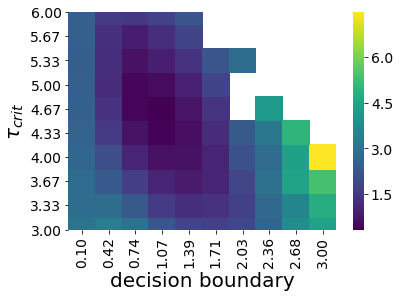

In [116]:
x_labels = ['%.2f' % (x) for x in grid[0].T[0]]
y_labels = ['%.2f' % (x) for x in grid[1][0]]
ax = sns.heatmap(jout.T, cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)
ax.invert_yaxis()
ax.set_xlabel('decision boundary')
ax.set_ylabel(r'$\tau_{crit}$');

In [117]:
i, j = np.unravel_index(np.nanargmin(jout), jout.shape)
params_opt = [grid[0][i][0], grid[1][0][j]]

In [118]:
print(f_wls(params_opt))

[1.0666666666666667, 4.666666666666666]
0.359445924369349
0.359445924369349


In [119]:
exp_measures = pd.read_csv('measures.csv')
sim_results = get_model_sim_results(params_opt)
sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))

[1.0666666666666667, 4.666666666666666]


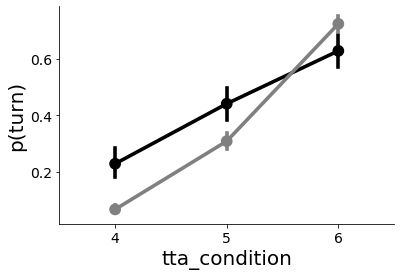

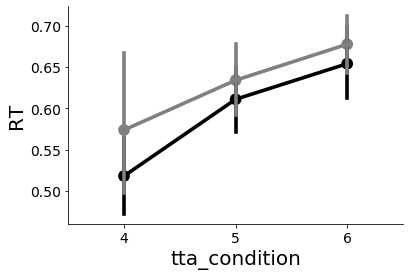

In [120]:
plot_comparison(exp_measures, sim_measures)

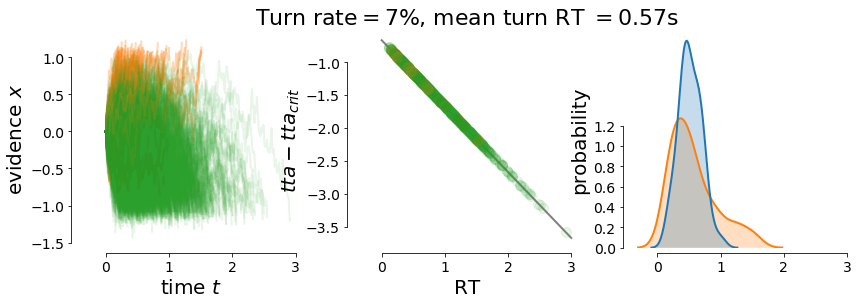

<Figure size 432x288 with 0 Axes>

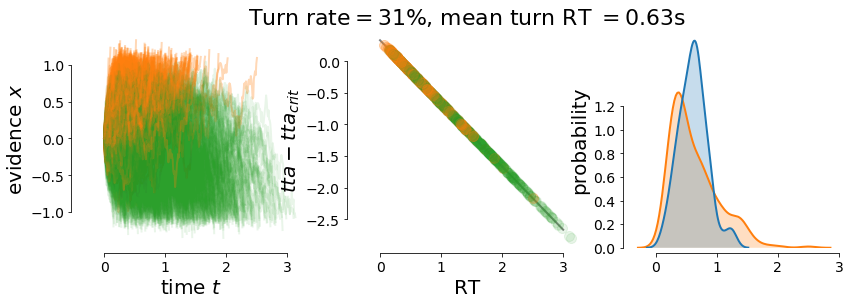

<Figure size 432x288 with 0 Axes>

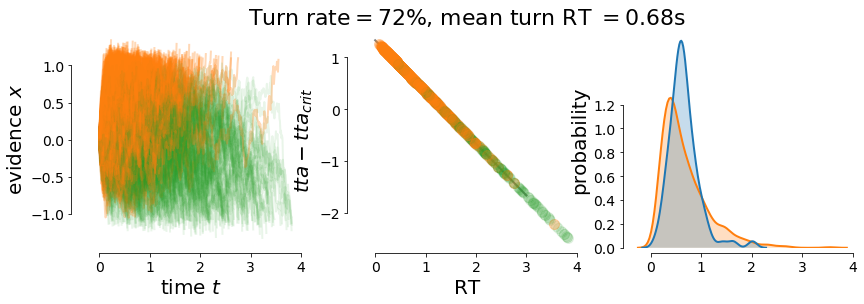

<Figure size 432x288 with 0 Axes>

In [122]:
def plot_model_sim(tta_condition):
    axes = plot_ddm_traces(sim_results[sim_results.tta_condition==tta_condition]);
    sns.kdeplot(data=exp_measures[exp_measures.is_turn_decision & (exp_measures.tta_condition==tta_condition)].RT, 
            color='C0', shade=True, legend=False, ax=axes[2])

for tta_condition in [4, 5, 6]:
    plot_model_sim(tta_condition)
    plt.figure()

# Trying PyDDM

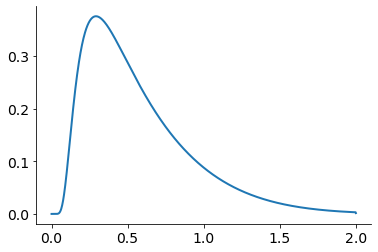

In [4]:
class DriftTta(ddm.Drift):
    name = 'Drift depends on time and critical TTA (parameter)'
    required_parameters = ['tta_crit']
    required_conditions = ['tta'] 
    
    def get_drift(self, t, conditions, **kwargs):
        return conditions['tta'] - self.tta_crit - t 
    
m = ddm.Model(drift=DriftTta(tta_crit=4.0),
              noise=ddm.NoiseConstant(noise=1.0),
              bound=ddm.BoundConstant(B=1.0))
s = m.solve(conditions={'tta': 4.0})
plt.plot(s.model.t_domain(), s.pdf_corr())

In [6]:
print(s.prob_correct(), s.mean_decision_time())

0.2411046924386214 0.5633052249555844
